In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [209]:
dataset = pd.read_csv('data/train.csv')
print(dataset.shape)
# Pixel0 ~ Pixel783までの計784カラム, sqrt(784) = 28 * 28 の画像データ
label_counts = dataset['label'].value_counts()
print(f'Label counts:\n {label_counts}')

(42000, 785)
Label counts:
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


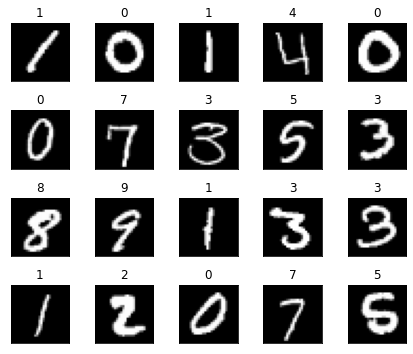

In [210]:
fig, ax = plt.subplots(4,5)
fig.set_figheight(5)
num_read_img = 20

for image_index in range(0,num_read_img):
    pixels = dataset.iloc[image_index,1:].values.reshape(28,28)
    draw_axis= ax[int(image_index/5),int(image_index%5)]
    draw_axis.imshow(pixels, cmap='gray')
    draw_axis.set_title(dataset.iloc[image_index,0])
    draw_axis.axes.xaxis.set_visible(False)
    draw_axis.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [211]:
label = dataset.loc[:,'label']
images = dataset.iloc[:,1:].values

# https://keras.io/ja/layers/convolutional/
# 入力: 'data_format='channels_first'の場合， (batch_size, channels, rows, cols)の4階テンソル'
#       'data_format='channels_last'の場合， (batch_size, rows, cols, channels)の4階テンソルになります．
# Conv2D層への入力のため、4次元にreshpae。 batsh_sizeはtrain_test_splitで変わるのですべてを意味する"-1"
images = images.reshape(-1,28,28,1)/255

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,label, test_size=0.1)
print(X_train.shape)

(37800, 28, 28, 1)


In [213]:
# CNNの初期化。単純なSequentialモデルで作成。
cnn = tf.keras.models.Sequential()

# 畳み込み https://keras.io/ja/layers/convolutional/
# 128x128 RGB画像ではinput_shape=(128, 128, 3)となります．
# 最初のレイヤーだけは、入り口となる入力シェイプが必要
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1], data_format='channels_last'))

# Poolingにより、ダウンサンプリング
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

# 2層目の中間層を追加
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

# Flattening
cnn.add(tf.keras.layers.Flatten())

# 接続
# unitsは   レイヤーの出力形状
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# 出力層
#cnn.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compiling the CNN
# 評価関数の選定 -> https://keras.io/ja/metrics/
cnn.compile(optimizer = 'adam', loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

In [222]:
# epochs: X_trainデータを塊に、それを学習しなおす回数
# batch_size: X_trainを小分けにし、過学習を避けるための分割数
print(X_train.shape)
answer = cnn.fit(X_train, y_train, epochs = 50, batch_size = 20)

(37800, 28, 28, 1)
Train on 37800 samples
Epoch 1/50
37800/37800 [==============================] - 34s 897us/sample - loss: 0.0041 - accuracy: 0.9986
Epoch 2/50
37800/37800 [==============================] - 31s 809us/sample - loss: 0.0034 - accuracy: 0.9989
Epoch 3/50
37800/37800 [==============================] - 28s 746us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 4/50
37800/37800 [==============================] - 27s 709us/sample - loss: 0.0033 - accuracy: 0.9991
Epoch 5/50
37800/37800 [==============================] - 27s 715us/sample - loss: 0.0036 - accuracy: 0.9990
Epoch 6/50
37800/37800 [==============================] - 27s 717us/sample - loss: 0.0035 - accuracy: 0.9991
Epoch 7/50
37800/37800 [==============================] - 27s 720us/sample - loss: 0.0030 - accuracy: 0.9990
Epoch 8/50
37800/37800 [==============================] - 28s 729us/sample - loss: 0.0036 - accuracy: 0.9990
Epoch 9/50
37800/37800 [==============================] - 27s 725us/sample - loss: 0.0

In [223]:
score = cnn.evaluate(X_test, y_test)

4200/4200 [==============================] - 1s 258us/sample - loss: 0.1736 - accuracy: 0.9898


In [224]:
y_pred = cnn.predict(X_test)
print(y_pred[0,:])
y_pred = np.argmax(y_pred,axis=1)
result_table = pd.DataFrame({ 'Predict': y_pred,
                            'Answer': y_test })
result_table.to_csv('prediction.csv', index=False)

[0.0000000e+00 1.0000000e+00 5.5537858e-18 2.4648861e-22 4.2433712e-23
 5.8478294e-24 1.2466029e-35 9.5435009e-28 2.2255450e-25 0.0000000e+00]


In [225]:
# モデルの保存
cnn.save('digit_recognizer.hdf5')